In [35]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn import metrics
from sklearn import decomposition 
import numpy as np
import matplotlib.pyplot as plt

import copy

In [5]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 9.91M/9.91M [00:17<00:00, 573kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 105kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 846kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.71MB/s]


In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data
    Split: Train

In [7]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [9]:
mean, std

(tensor(0.1307), tensor(0.3081))

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [12]:
train_transforms

Compose(
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=(0,))
    RandomCrop(size=(28, 28), padding=2)
    ToTensor()
    Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
)

In [14]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [15]:
test_transforms

Compose(
    ToTensor()
    Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
)

In [17]:
train_data = datasets.MNIST(root=ROOT,
                           train=True,
                           download=True,
                           transform=train_transforms)

In [18]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=(0,))
               RandomCrop(size=(28, 28), padding=2)
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

In [19]:
test_data = datasets.MNIST(root=ROOT,
                          train=False,
                          download=True,
                          transform=test_transforms)

In [20]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: .data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

In [27]:
def plot_images(images):
    rows = int(np.sqrt(len(images)))
    cols = int(np.sqrt(len(images)))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28,28), cmap='bone')
        ax.axis('off')

In [28]:
N_images = 25
images = [image for image, label in [train_data[i] for i in range(N_images)]]

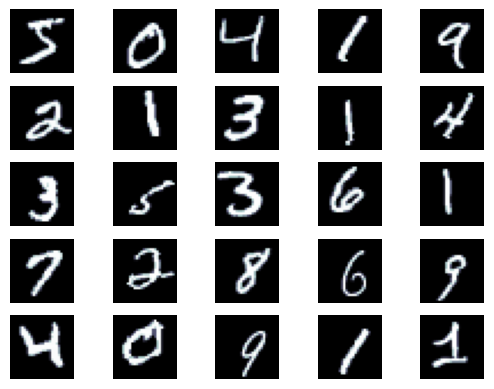

In [29]:
plot_images(images)

In [32]:
VALID_RATIO = 0.90
n_train_examples = int(len(train_data)*VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [33]:
train_data, valid_data = data.rarandom_split(train_data, [n_train_examples, n_valid_examples])

In [34]:
len(valid_data)

6000

In [36]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transforms = test_transforms

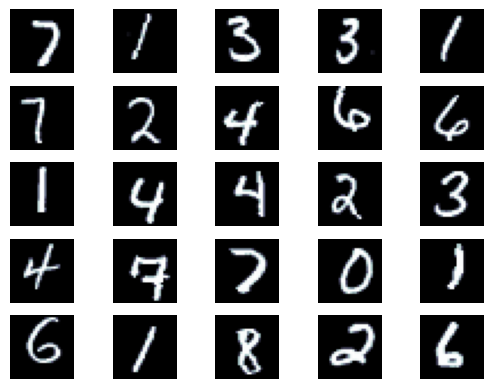

In [38]:
N_images = 25
images = [image for image, label in [valid_data[i] for i in range(N_images)]]
plot_images(images)

In [39]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [48]:
class MLP(nn.Module):
    def __init__(self, input_dim, out_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250,100)
        self.output_fc = nn.Linear(100, out_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)

        return y_pred, h_2

In [49]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [51]:
count_parameters(model)

222360